In [1]:
import shapely
import matplotlib
import pandas as pd
import numpy  as np
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc

np.random.seed(42)

- 参考：https://github.com/mikhailsirenko/bivariate-choropleth

## 空间数据

<Axes: >

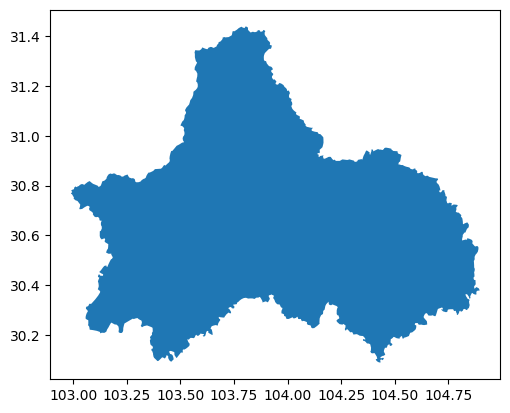

In [2]:
gdf = gpd.read_file('../data/chengdu.geojson')
gdf.plot()

In [3]:
def make_grid(boundary: gpd.GeoDataFrame, radius: float) -> gpd.GeoDataFrame:
    # 以边界的中心点按照radius半径进行外扩
    minx, miny, maxx, maxy = boundary.total_bounds
    deltax = ((maxx-minx)%(radius*2)) / 2
    deltay = ((maxy-miny)%(radius*2)) / 2
    minx -= deltax
    maxx += deltax
    miny -= deltay
    maxy += deltay
    cells = []
    for x in np.arange(minx, maxx, radius*2):
        for y in np.arange(miny, maxy, radius*2):
            cells.append(shapely.geometry.Polygon([(x,y),(x,y+radius*2),(x+radius*2,y+radius*2),(x+radius*2,y),(x,y)]))
    return gpd.GeoDataFrame(cells,columns=['geometry'],crs=boundary.crs).sjoin(boundary,how='inner')  

In [4]:
grid = make_grid(gdf, 0.02)  # 按照 0.02 / 2 度划分格网
grid = grid.drop(columns='index_right').reset_index(drop=True)

# 添加 FID 用于数值连接
grid['FID'] = grid.index

grid

,geometry,地级码,地级,省级,省级码,FID
0,"POLYGON ((102.97630 30.71759, 102.97630 30.757...",510100,成都市,四川省,510000,0
1,"POLYGON ((102.97630 30.75759, 102.97630 30.797...",510100,成都市,四川省,510000,1
2,"POLYGON ((103.01630 30.67759, 103.01630 30.717...",510100,成都市,四川省,510000,2
3,"POLYGON ((103.01630 30.71759, 103.01630 30.757...",510100,成都市,四川省,510000,3
4,"POLYGON ((103.01630 30.75759, 103.01630 30.797...",510100,成都市,四川省,510000,4
...,...,...,...,...,...,...
941,"POLYGON ((104.85630 30.39759, 104.85630 30.437...",510100,成都市,四川省,510000,941
942,"POLYGON ((104.85630 30.43759, 104.85630 30.477...",510100,成都市,四川省,510000,942
943,"POLYGON ((104.85630 30.47759, 104.85630 30.517...",510100,成都市,四川省,510000,943
944,"POLYGON ((104.85630 30.51759, 104.85630 30.557...",510100,成都市,四川省,510000,944


<Axes: >

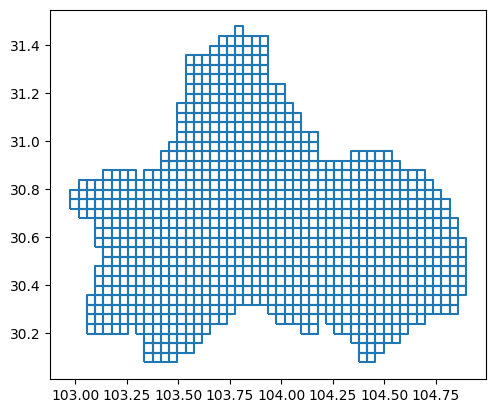

In [5]:
grid.boundary.plot()

## 随机数

In [6]:
samples = np.random.rand(956, 2)
df = pd.DataFrame(samples, columns=["x", "y"])

df['FID'] = df.index
df

,x,y,FID
0,0.374540,0.950714,0
1,0.731994,0.598658,1
2,0.156019,0.155995,2
3,0.058084,0.866176,3
4,0.601115,0.708073,4
...,...,...,...
951,0.760991,0.035311,951
952,0.745734,0.202481,952
953,0.958073,0.367941,953
954,0.326932,0.148888,954


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

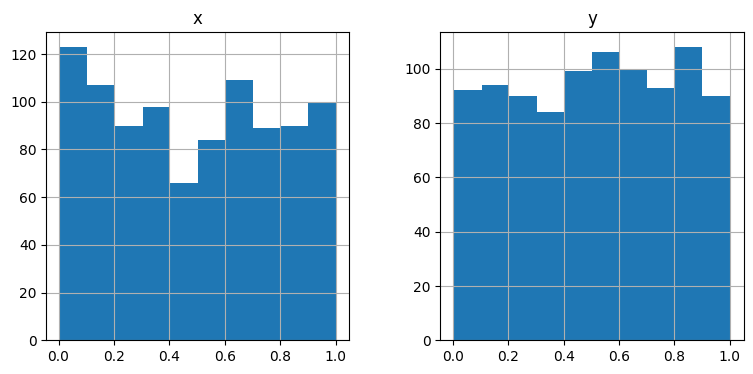

In [7]:
df[['x','y']].hist(figsize=(9,4))

- 作者介绍，这里可以采用多种数据分箱方法：
    - 使用用户定义的分箱（作者的方法），
    - 计算分位数（Quantiles），
    - 使用自然断点（Natural Breaks）等。

In [8]:
# 使用自然断点进行分箱（3个类别）
nb_x = mc.NaturalBreaks(df['x'], k=3)
nb_y = mc.NaturalBreaks(df['y'], k=3)

# 获取 bin 边界
bins_x = nb_x.bins
bins_y = nb_y.bins

# 进行分箱
df['Var1_Class'] = pd.cut(df['x'], bins=[df['x'].min()] + list(bins_x), labels=[1, 2, 3], include_lowest=True)
df['Var2_Class'] = pd.cut(df['y'], bins=[df['y'].min()] + list(bins_y), labels=['A', 'B', 'C'], include_lowest=True)

# 组合分类
df['Bi_Class'] = df['Var1_Class'].astype(object).astype(str) + df['Var2_Class'].astype(object).astype(str)

In [9]:
df

,x,y,FID,Var1_Class,Var2_Class,Bi_Class
0,0.374540,0.950714,0,2,C,2C
1,0.731994,0.598658,1,3,B,3B
2,0.156019,0.155995,2,1,A,1A
3,0.058084,0.866176,3,1,C,1C
4,0.601115,0.708073,4,2,C,2C
...,...,...,...,...,...,...
951,0.760991,0.035311,951,3,A,3A
952,0.745734,0.202481,952,3,A,3A
953,0.958073,0.367941,953,3,B,3B
954,0.326932,0.148888,954,1,A,1A


In [10]:
print('Number of unique elements in Var1_Class =', len(df['Var1_Class'].unique()))
print('Number of unique elements in Var2_Class =', len(df['Var2_Class'].unique()))
print('Number of unique elements in Bi_Class =', len(df['Bi_Class'].unique()))

Number of unique elements in Var1_Class = 3
Number of unique elements in Var2_Class = 3
Number of unique elements in Bi_Class = 9


## 设置颜色

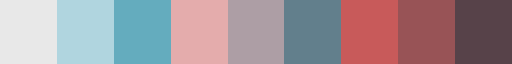

In [11]:
# All colors to create a complete legend
all_colors = ['#e8e8e8', '#b0d5df', '#64acbe', '#e4acac', '#ad9ea5', '#627f8c', '#c85a5a', '#985356', '#574249']
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

## 双变量地图

In [12]:
grid0 = grid.merge(df, on='FID', how='left')
grid0

,geometry,地级码,地级,省级,省级码,FID,x,y,Var1_Class,Var2_Class,Bi_Class
0,"POLYGON ((102.97630 30.71759, 102.97630 30.757...",510100,成都市,四川省,510000,0,0.374540,0.950714,2,C,2C
1,"POLYGON ((102.97630 30.75759, 102.97630 30.797...",510100,成都市,四川省,510000,1,0.731994,0.598658,3,B,3B
2,"POLYGON ((103.01630 30.67759, 103.01630 30.717...",510100,成都市,四川省,510000,2,0.156019,0.155995,1,A,1A
3,"POLYGON ((103.01630 30.71759, 103.01630 30.757...",510100,成都市,四川省,510000,3,0.058084,0.866176,1,C,1C
4,"POLYGON ((103.01630 30.75759, 103.01630 30.797...",510100,成都市,四川省,510000,4,0.601115,0.708073,2,C,2C
...,...,...,...,...,...,...,...,...,...,...,...
941,"POLYGON ((104.85630 30.39759, 104.85630 30.437...",510100,成都市,四川省,510000,941,0.636291,0.761122,2,C,2C
942,"POLYGON ((104.85630 30.43759, 104.85630 30.477...",510100,成都市,四川省,510000,942,0.160072,0.461557,1,B,1B
943,"POLYGON ((104.85630 30.47759, 104.85630 30.517...",510100,成都市,四川省,510000,943,0.009332,0.246679,1,A,1A
944,"POLYGON ((104.85630 30.51759, 104.85630 30.557...",510100,成都市,四川省,510000,944,0.726462,0.991810,3,C,3C


In [13]:
def plot_binning_legend(fig, position, all_colors, alpha=1):
    """
    在指定位置绘制分箱图例。
    
    参数：
    fig : matplotlib.figure.Figure
        主图对象。
    position : list
        位置列表 [left, bottom, width, height]。
    all_colors : list
        颜色列表，必须包含 9 种颜色。
    alpha : float, optional
        透明度，默认为 1。
    """
    ax2 = fig.add_axes(position)  # 在指定位置添加新坐标轴
    
    # Column 1
    ax2.axvspan(xmin=0, xmax=0.33, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[0])
    ax2.axvspan(xmin=0, xmax=0.33, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[1])
    ax2.axvspan(xmin=0, xmax=0.33, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[2])
    
    # Column 2
    ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[3])
    ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[4])
    ax2.axvspan(xmin=0.33, xmax=0.66, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[5])
    
    # Column 3
    ax2.axvspan(xmin=0.66, xmax=1, ymin=0, ymax=0.33, alpha=alpha, color=all_colors[6])
    ax2.axvspan(xmin=0.66, xmax=1, ymin=0.33, ymax=0.66, alpha=alpha, color=all_colors[7])
    ax2.axvspan(xmin=0.66, xmax=1, ymin=0.66, ymax=1, alpha=alpha, color=all_colors[8])
    
    # 取消坐标轴
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.axis('off')
    
    # 添加箭头和文本标注
    ax2.annotate("", xy=(0, 1), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))  # x 轴箭头
    ax2.annotate("", xy=(1, 0), xytext=(0, 0), arrowprops=dict(arrowstyle="->", lw=1))  # y 轴箭头
    ax2.text(s='Var1_Class', x=0.1, y=-0.25)  # x 轴标签
    ax2.text(s='Var2_Class', x=-0.25, y=0.1, rotation=90)  # y 轴标签
    
    return ax2

### cmap1

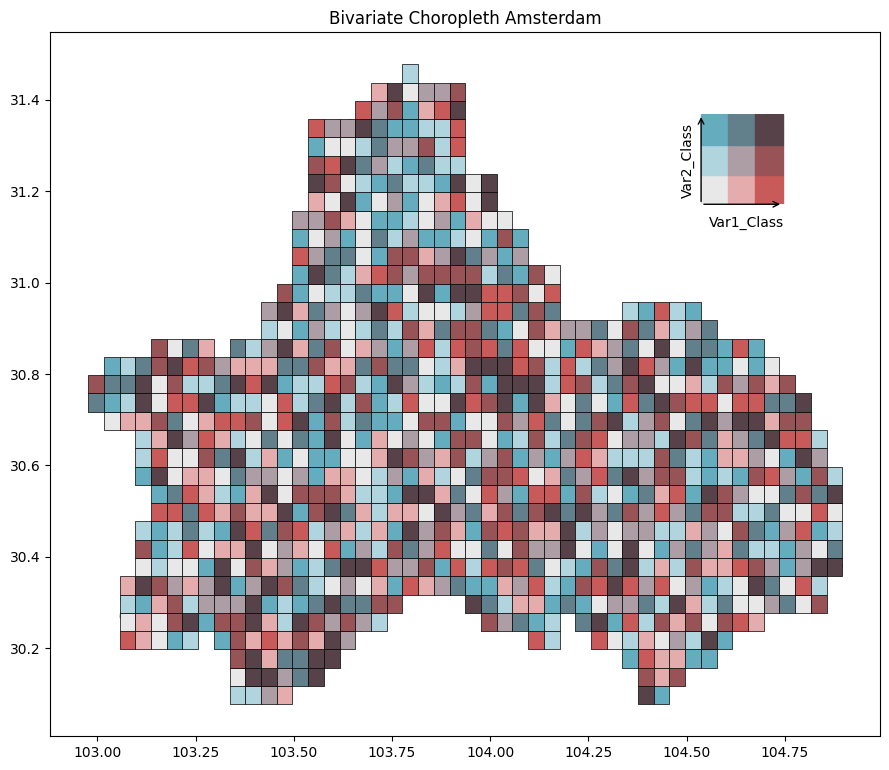

In [14]:
fig, ax = plt.subplots(figsize=(9,9))

# map
gdf.plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)
grid0.plot(ax=ax, column='Bi_Class', cmap=cmap, lw=0.5, ec='k', categorical=True, legend=False) 
ax.set_title('Bivariate Choropleth Amsterdam')
plt.tight_layout()

# legend
plot_binning_legend(fig=fig, position=[0.78, 0.7, 0.1, 0.1], all_colors=all_colors, alpha=1)  
# [0.78, 0.7, 0.1, 0.1]: 0.78和0.7空值左下角位置，调整这两个参数就行；后面的两个参数为右上角能调整宽度
plt.show()

### cmap2

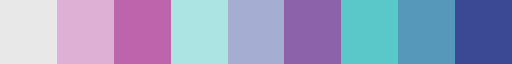

In [15]:
all_colors = ['#e8e8e8', '#dfb0d6', '#be64ac', '#ace4e4', '#a5add3', '#8c62aa', '#5ac8c8', '#5698b9', '#3b4994']
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

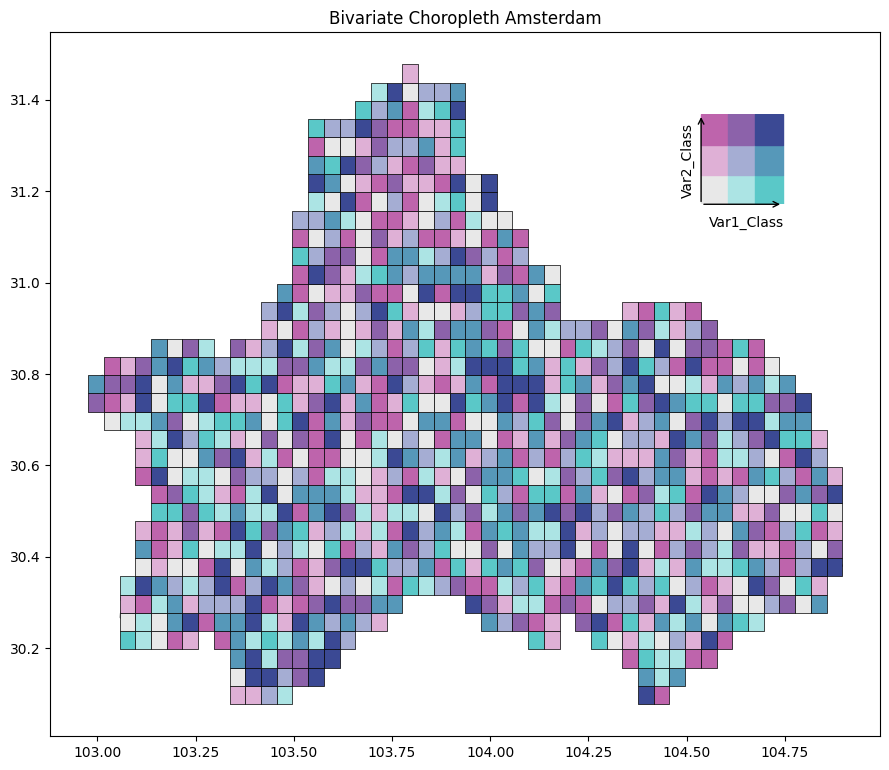

In [16]:
fig, ax = plt.subplots(figsize=(9,9))

# map
gdf.plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)
grid0.plot(ax=ax, column='Bi_Class', cmap=cmap, lw=0.5, ec='k', categorical=True, legend=False) 
ax.set_title('Bivariate Choropleth Amsterdam')
plt.tight_layout()

# legend
plot_binning_legend(fig=fig, position=[0.78, 0.7, 0.1, 0.1], all_colors=all_colors, alpha=1)  
# [0.78, 0.7, 0.1, 0.1]: 0.78和0.7空值左下角位置，调整这两个参数就行；后面的两个参数为右上角能调整宽度
plt.show()

### cmap3

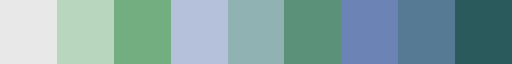

In [17]:
all_colors = ['#e8e8e8', '#b8d6be', '#73ae80', '#b5c0da', '#90b2b3', '#5a9178', '#6c83b5', '#567994', '#2a5a5b']
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

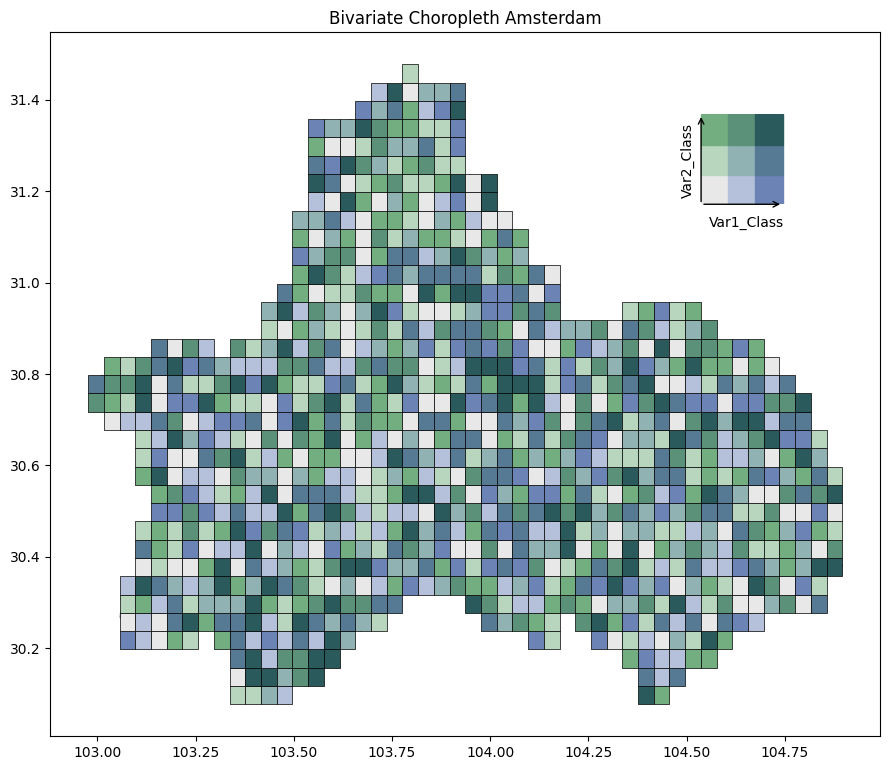

In [18]:
fig, ax = plt.subplots(figsize=(9,9))

# map
gdf.plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)
grid0.plot(ax=ax, column='Bi_Class', cmap=cmap, lw=0.5, ec='k', categorical=True, legend=False) 
ax.set_title('Bivariate Choropleth Amsterdam')
plt.tight_layout()

# legend
plot_binning_legend(fig=fig, position=[0.78, 0.7, 0.1, 0.1], all_colors=all_colors, alpha=1)  
# [0.78, 0.7, 0.1, 0.1]: 0.78和0.7空值左下角位置，调整这两个参数就行；后面的两个参数为右上角能调整宽度
plt.show()

### cmap4

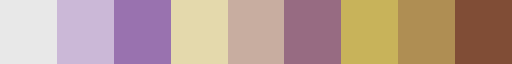

In [19]:
all_colors = ['#e8e8e8', '#cbb8d7', '#9972af', '#e4d9ac', '#c8ada0', '#976b82', '#c8b35a', '#af8e53', '#804d36']
cmap = matplotlib.colors.ListedColormap(all_colors)
cmap

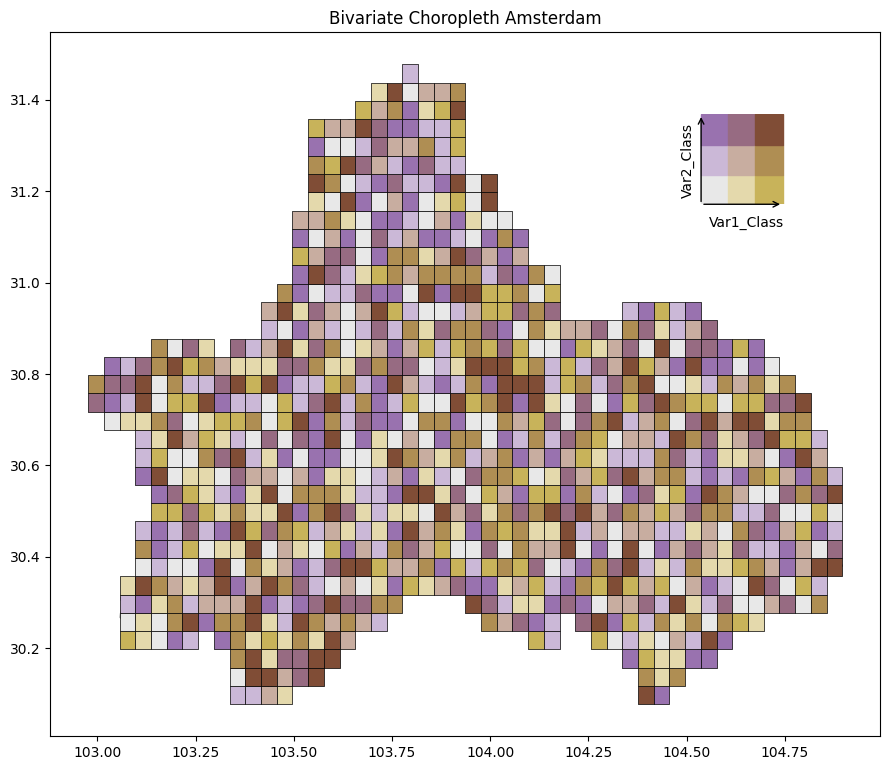

In [20]:
fig, ax = plt.subplots(figsize=(9,9))

# map
gdf.plot(ax=ax, facecolor='none', edgecolor='black', alpha=.5)
grid0.plot(ax=ax, column='Bi_Class', cmap=cmap, lw=0.5, ec='k', categorical=True, legend=False) 
ax.set_title('Bivariate Choropleth Amsterdam')
plt.tight_layout()

# legend
plot_binning_legend(fig=fig, position=[0.78, 0.7, 0.1, 0.1], all_colors=all_colors, alpha=1)  
# [0.78, 0.7, 0.1, 0.1]: 0.78和0.7空值左下角位置，调整这两个参数就行；后面的两个参数为右上角能调整宽度
plt.show()